In [1]:
import sys
sys.path.insert(0, '../src/')

from DataCollector import DataCollector
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# graphics settings
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcdefaults()
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# COLLECT DATA, THIS REQUIRES TIME... WAIT UNTIL FINISH BEFORE RUNNING NEXT CELLS

dataCollector = DataCollector()

# write a fresh CSV file containing data for the selected period
# avoid to call this function if you already have a dataset, call updateData() instead
BEGIN_DATE = "2020-06-01"
END_DATE   = "2020-10-25"
dataCollector.getData(BEGIN_DATE, END_DATE, "../data/rawdata.csv")

# automatically update dataset with data up to yesterday
# dataCollector.updateData("data.csv")

fetching data from Wiseair server


In [ ]:
data = pd.read_csv("../data/rawdata.csv")
data["created_at"] = pd.to_datetime(data["created_at"])
data.set_index("created_at", inplace=True)

data.info()

In [5]:
# keep only interesting features
interesting = ["pm1SPS", "pm2p5SPS", "pm4SPS", "pm10SPS", "temperature_sht", "humidity_sht", 
               "pot_id", "lat", "lon"]

for feature in list(data.columns.values):
    if feature not in interesting:
        data.drop(feature, axis = 1, inplace = True)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 551888 entries, 2020-09-04 22:23:31 to 2020-10-21 16:45:00
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pot_id           551888 non-null  int64  
 1   pm1SPS           551888 non-null  float64
 2   pm2p5SPS         551888 non-null  int64  
 3   pm4SPS           551888 non-null  float64
 4   pm10SPS          551888 non-null  float64
 5   temperature_sht  551888 non-null  float64
 6   humidity_sht     551888 non-null  float64
 7   lat              551888 non-null  float64
 8   lon              551888 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 42.1 MB


In [6]:
data.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,lat,lon
created_at,,,,,,,,,
2020-09-04 22:23:31,1157,9.39,10,9.93,9.93,-9.05,20.52,41.826132,12.395317
2020-09-04 22:25:28,1157,12.54,13,13.26,13.26,-7.86,17.70,41.826132,12.395317
2020-09-04 22:30:15,1157,13.30,14,14.06,14.06,-8.53,29.28,41.826132,12.395317
2020-09-04 22:35:14,1157,12.75,13,13.49,13.49,-8.60,26.16,41.826132,12.395317
2020-09-04 22:40:14,1157,13.28,14,14.04,14.04,-8.67,25.66,41.826132,12.395317


## Weather data integration

wheater data are available with hourly frequency. Need to average available data hourly before integrating further informations from ARPA sensors. Data from ARPA sensors are joined to Wiseair data on the base of the datetime index. Be carefull to use ARPA data up to dated with respect to data collected from Wiseair (otherwise athmospheric informations as wind speed and rain levels will be NaN for days for which no data are supplied)

In [ ]:
# group data on base of sensors id
groupedData = data.groupby('pot_id', as_index=False)

averagedData = pd.DataFrame()
potID = set(data['pot_id'])

# average data by sensor id
for y in potID:
    tmp = groupedData.get_group(y).resample('H').mean()
    tmp['pot_id'] = tmp['pot_id'].fillna(y)
    tmp['lat'] = tmp['lat'].fillna(method = "ffill")
    tmp['lon'] = tmp['lon'].fillna(method = "ffill")
    averagedData = pd.concat([averagedData, tmp])

# recast pot_id to integer
averagedData['pot_id'] = averagedData['pot_id'].astype(int)

averagedData.head()

In [ ]:
endDate = datetime.strptime(END_DATE, "%Y-%m-%d")
endDate

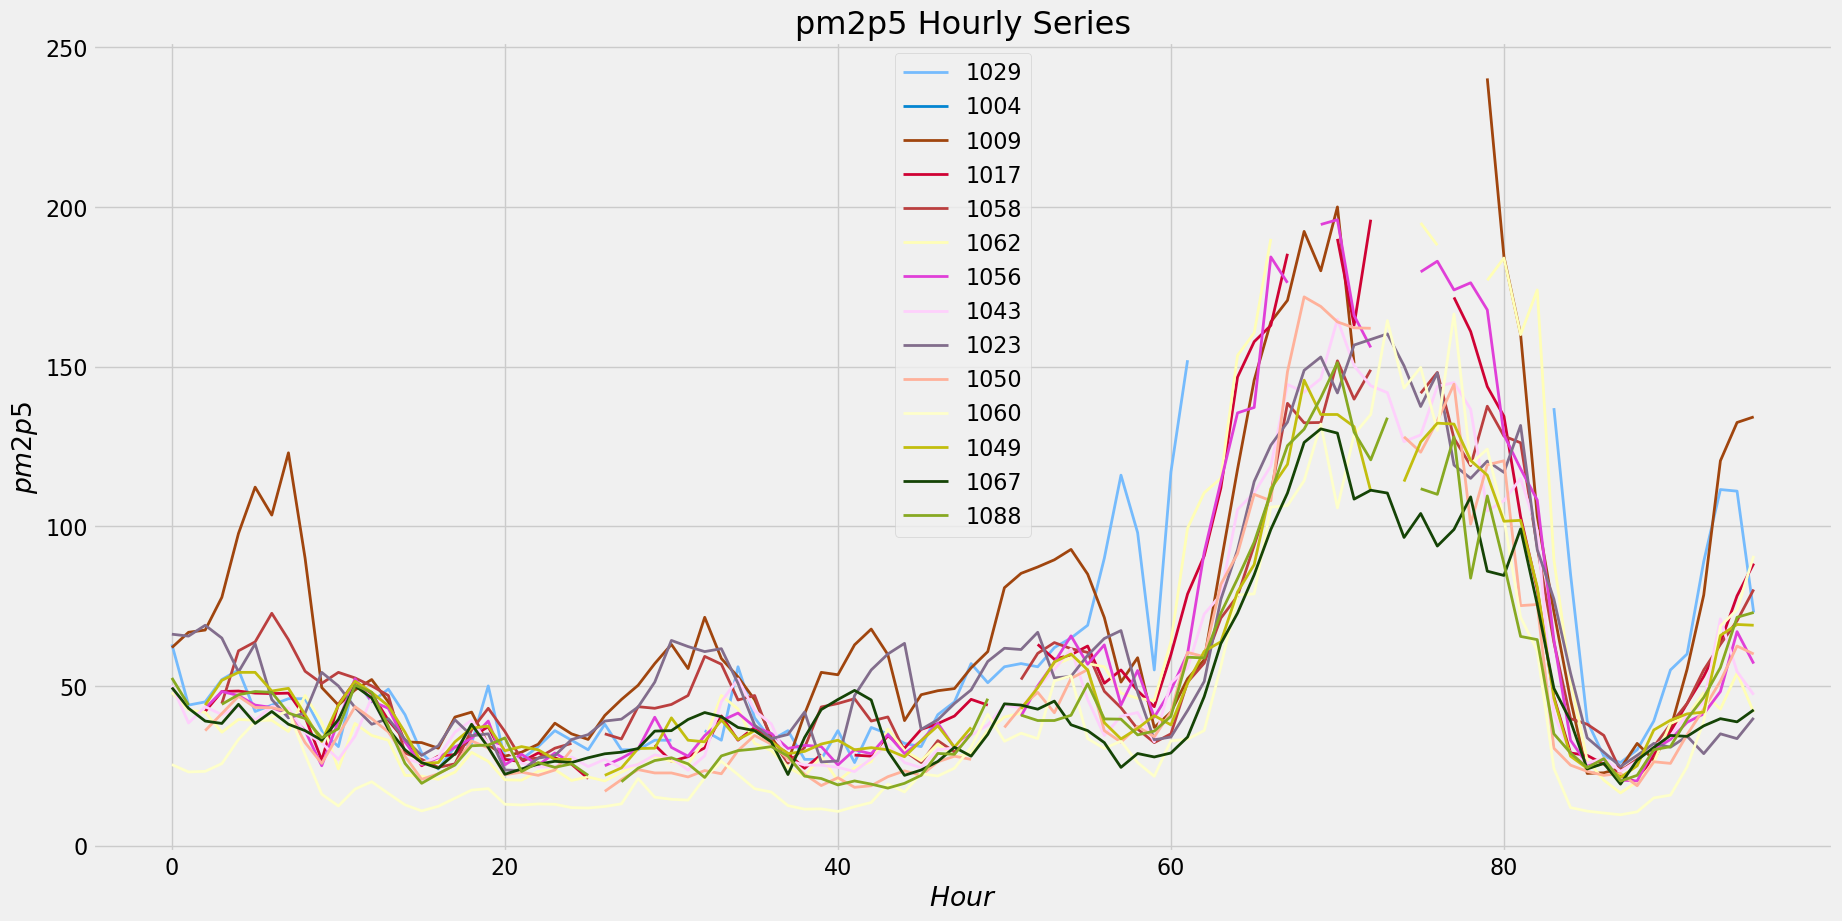

In [8]:
# just a plot to show some data... only the last 4 days are showed

endDate = datetime.strptime(END_DATE, "%Y-%m-%d")
startDate = endDate - timedelta(days = 4)

sensorsToPlot = [1029, 1004, 1009, 1017, 1058, 1062, 1056, 1043, 1023, 1050, 1060, 1049, 1067, 1088]
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(sensorsToPlot), replace=False)

plt.figure(figsize=(8,6))
for j,i in enumerate(sensorsToPlot):
    tmp = averagedData.loc[averagedData['pot_id'] == i]
    tmp = tmp[startDate : endDate]
    
    tmp['hour'] = [d.strftime('%H') for d in tmp.index]
    tmp['colid'] = range(len(tmp['hour']))
    plt.plot('colid', 'pm2p5SPS', data=tmp, color=mycolors[j], label=i)
        
plt.gcf().set_size_inches(20, 10)
plt.gca().set(ylabel='$pm2p5$', xlabel='$Hour$')
plt.title("pm2p5 Hourly Series")
plt.legend()
plt.show()

In [9]:
# weather data integration (data from 01-05-2020 to 25-10-2020)

# importing data from external files...
windSpeed = pd.read_csv('../data/datiArpaVento-01052020-25102020.csv', 
                        names=["ID", "Date", "windSpeed"], header=0)
windSpeed.drop("ID", axis = 1, inplace = True)
windSpeed["Date"] = pd.to_datetime(windSpeed["Date"])
windSpeed.set_index("Date", inplace=True)

rainLevel = pd.read_csv('../data/datiArpaPrecipitazioni-01052020-25102020.csv', 
                        names=["ID", "Date", "rain"], header=0)
rainLevel.drop("ID", axis = 1, inplace = True)
rainLevel["Date"] = pd.to_datetime(rainLevel["Date"])
rainLevel.set_index("Date", inplace=True)

In [10]:
# dataset merge
finalData = pd.concat([averagedData, windSpeed], join='inner', axis=1)
finalData = pd.concat([finalData, rainLevel], join='inner', axis=1)

finalData.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,lat,lon,windSpeed,rain
2020-06-24 17:00:00,1024,7.02875,7.625000,7.502500,7.508750,35.715000,32.99125,45.458286,9.16756,2.0,0.0
2020-06-24 18:00:00,1024,5.52750,6.083333,6.405833,6.456667,35.633333,34.51250,45.458286,9.16756,1.8,0.0
2020-06-24 19:00:00,1024,5.91750,6.625000,6.907500,6.965000,34.972500,31.95875,45.458286,9.16756,1.7,0.0
2020-06-24 20:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.16756,1.4,0.0
2020-06-24 21:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.16756,2.0,0.0


In [39]:
finalData

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,lat,lon,windSpeed,rain
created_at,,,,,,,,,,,
2020-06-24 17:00:00,1024,7.02875,7.625000,7.502500,7.508750,35.715000,32.99125,45.458286,9.167560,2.0,0.0
2020-06-24 18:00:00,1024,5.52750,6.083333,6.405833,6.456667,35.633333,34.51250,45.458286,9.167560,1.8,0.0
2020-06-24 19:00:00,1024,5.91750,6.625000,6.907500,6.965000,34.972500,31.95875,45.458286,9.167560,1.7,0.0
2020-06-24 20:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.167560,1.4,0.0
2020-06-24 21:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.167560,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-24 19:00:00,1023,37.26750,34.250000,43.095000,43.422500,10.197500,70.00000,45.402550,9.203925,0.0,0.0
2020-10-24 20:00:00,1023,31.77400,28.800000,35.760000,35.954000,10.416000,70.00000,45.402550,9.203925,0.0,0.0
2020-10-24 21:00:00,1023,36.65000,35.000000,44.907500,45.457500,10.812500,70.00000,45.402550,9.203925,0.0,0.0


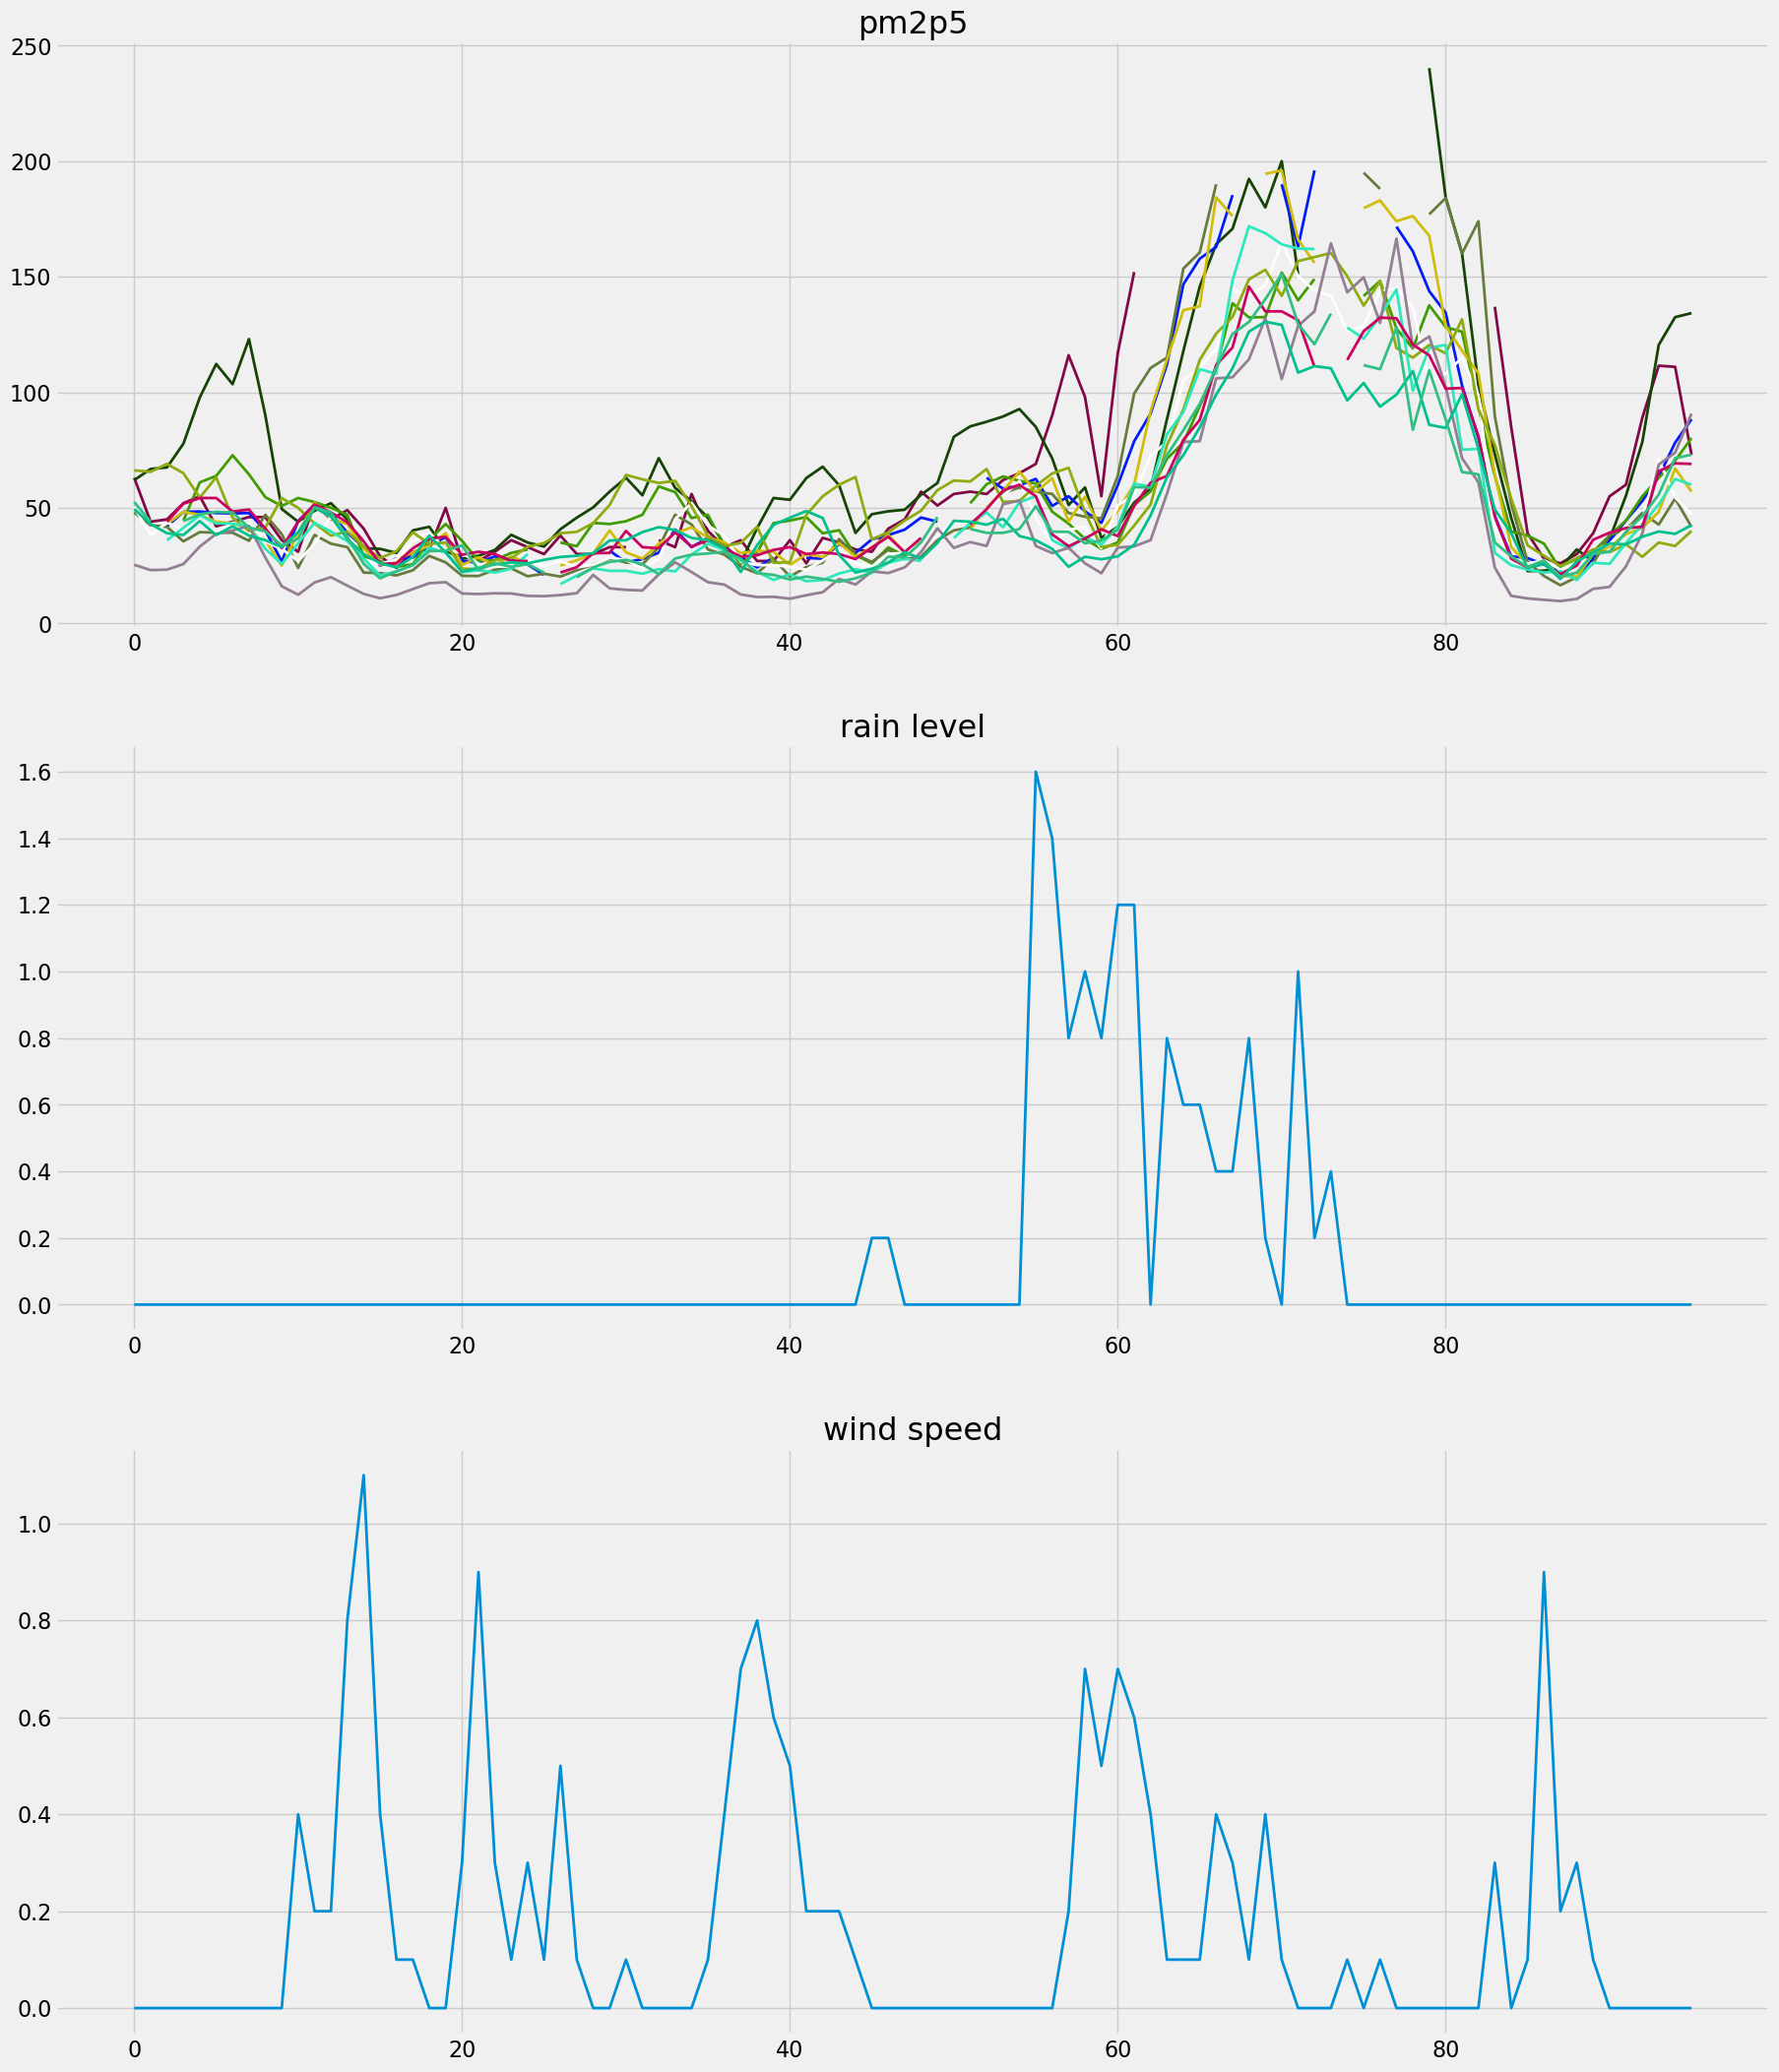

In [11]:
# final plot to show some covariates as function of time. Only the last 4 days are showed

sensorsToPlot = [1029, 1004, 1009, 1017, 1058, 1062, 1056, 1043, 1023, 1050, 1060, 1049, 1067, 1088]
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(sensorsToPlot), replace=False)

fig, axs = plt.subplots(3)
for j,i in enumerate(sensorsToPlot):
    tmp = finalData.loc[finalData['pot_id'] == i]
    tmp = tmp[startDate : endDate]
    
    tmp['hour'] = [d.strftime('%H') for d in tmp.index]
    tmp['colid'] = range(len(tmp['hour']))
    axs[0].plot('colid', 'pm2p5SPS', data=tmp, color=mycolors[j], label=i)

axs[1].plot('colid', 'rain', data=tmp)
axs[2].plot('colid', 'windSpeed', data=tmp)

axs[0].set_title("pm2p5")
axs[1].set_title("rain level")
axs[2].set_title("wind speed")

plt.gcf().set_size_inches(20, 25)
plt.show()

The final dataset can now be esported in csv and used for next studies

In [12]:
finalData.index.name = "created_at"
finalData.to_csv("../data/tsData.csv")

In [13]:
all_data_na = (finalData.isnull().sum() / len(finalData)) * 100


In [15]:
all_data_na.head()



pot_id       0.000000
pm1SPS      33.208515
pm2p5SPS    33.208515
pm4SPS      33.208515
pm10SPS     33.208515
dtype: float64

In [16]:
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)


,Missing Ratio
humidity_sht,33.208515
temperature_sht,33.208515
pm10SPS,33.208515
pm4SPS,33.208515
pm2p5SPS,33.208515
pm1SPS,33.208515


missing_data.created_at.head()

In [18]:
import seaborn as sns

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr

Text(0.5, 1.0, 'Top Variables for % of Missing Values')

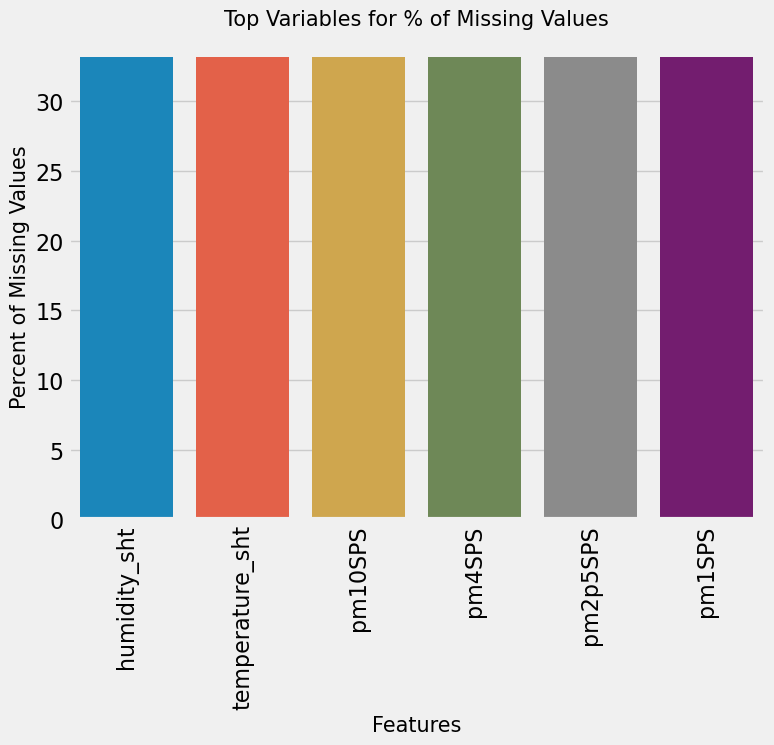

In [19]:
f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index[:10], y=all_data_na[:10])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Top Variables for % of Missing Values', fontsize=15)

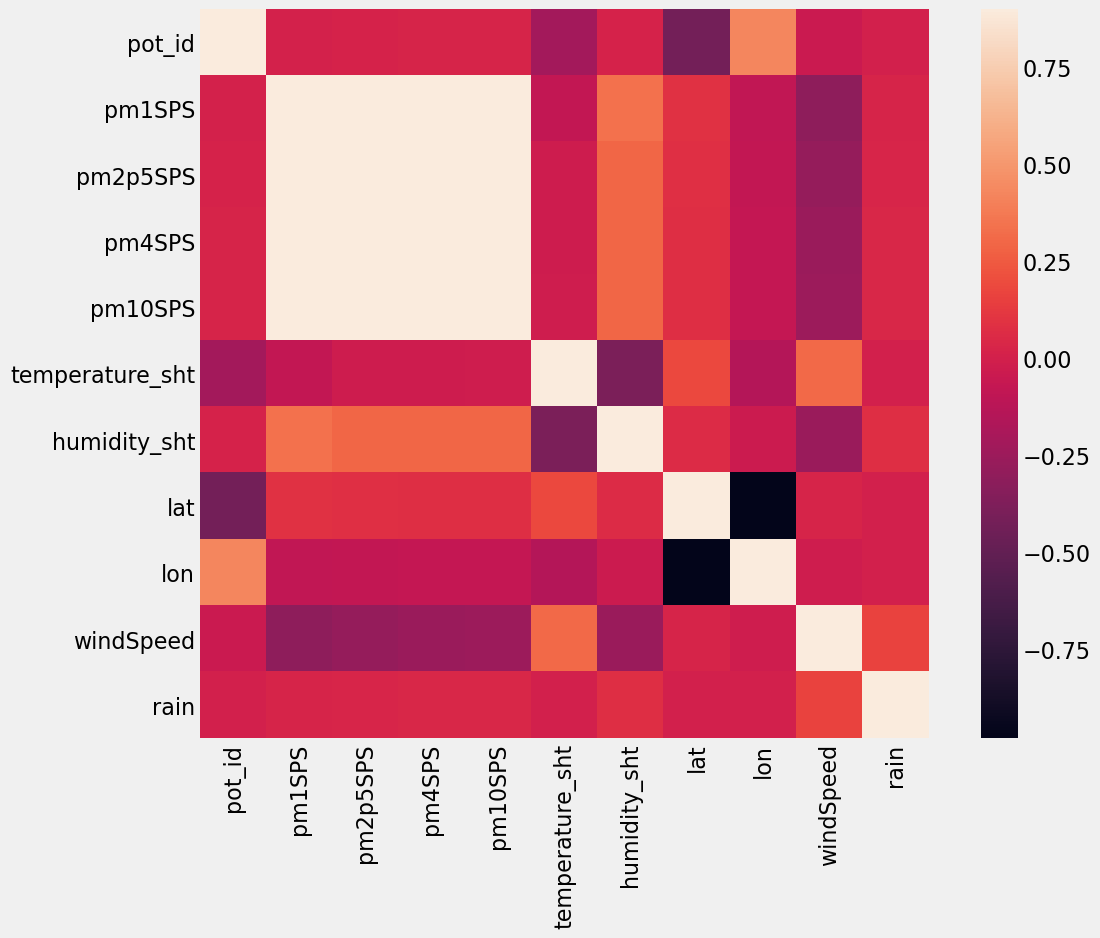

In [20]:
corrmat = finalData.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True);

<Figure size 1200x900 with 0 Axes>

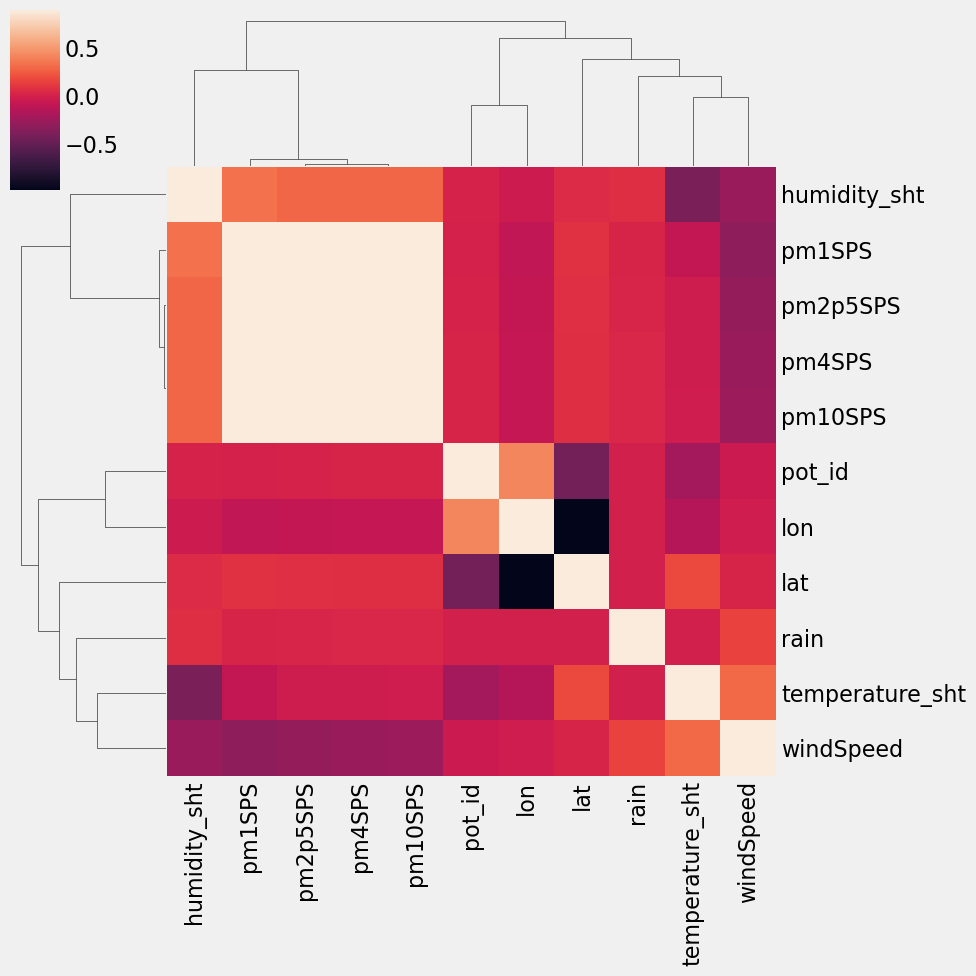

In [21]:
import seaborn as sns
plt.figure(figsize=(12,9))
sns.clustermap(corrmat, vmax=0.9, square=True);

In [43]:
finalData.dropna()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,lat,lon,windSpeed,rain
created_at,,,,,,,,,,,
2020-06-24 17:00:00,1024,7.02875,7.625000,7.502500,7.508750,35.715000,32.99125,45.458286,9.167560,2.0,0.0
2020-06-24 18:00:00,1024,5.52750,6.083333,6.405833,6.456667,35.633333,34.51250,45.458286,9.167560,1.8,0.0
2020-06-24 19:00:00,1024,5.91750,6.625000,6.907500,6.965000,34.972500,31.95875,45.458286,9.167560,1.7,0.0
2020-06-25 00:00:00,1024,4.53100,5.400000,5.660000,5.737000,30.809000,32.37100,45.458286,9.167560,1.8,0.0
2020-06-25 01:00:00,1024,3.31000,4.000000,4.390000,4.470000,28.210000,34.16000,45.458286,9.167560,1.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-24 19:00:00,1023,37.26750,34.250000,43.095000,43.422500,10.197500,70.00000,45.402550,9.203925,0.0,0.0
2020-10-24 20:00:00,1023,31.77400,28.800000,35.760000,35.954000,10.416000,70.00000,45.402550,9.203925,0.0,0.0
2020-10-24 21:00:00,1023,36.65000,35.000000,44.907500,45.457500,10.812500,70.00000,45.402550,9.203925,0.0,0.0


In [46]:
daily_returns = finalData.pct_change().dropna()

In [47]:
daily_returns

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,lat,lon,windSpeed,rain
created_at,,,,,,,,,,,
2020-07-01 08:00:00,0.0,0.732968,0.444444,0.271284,0.248296,0.007903,0.010617,0.0,0.0,0.222222,inf
2020-07-01 09:00:00,0.0,0.086760,0.000000,-0.049271,-0.059365,-0.045844,0.103724,0.0,0.0,0.454545,0.00
2020-07-01 10:00:00,0.0,0.429522,0.461538,0.375547,0.371418,0.020108,0.120297,0.0,0.0,-0.312500,-0.50
2020-07-01 11:00:00,0.0,-0.403432,-0.394737,-0.368798,-0.365776,0.086050,-0.059513,0.0,0.0,0.090909,-1.00
2020-07-02 01:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-0.176471,inf
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-23 20:00:00,0.0,-0.023846,0.122423,0.202388,0.215976,0.013367,0.000000,0.0,0.0,-0.666667,1.00
2020-10-23 21:00:00,0.0,0.081924,0.027996,0.005162,0.001477,0.006103,0.000000,0.0,0.0,3.000000,-0.75
2020-10-23 22:00:00,0.0,0.003440,-0.073529,-0.107560,-0.113344,0.048631,0.000000,0.0,0.0,-0.750000,-1.00


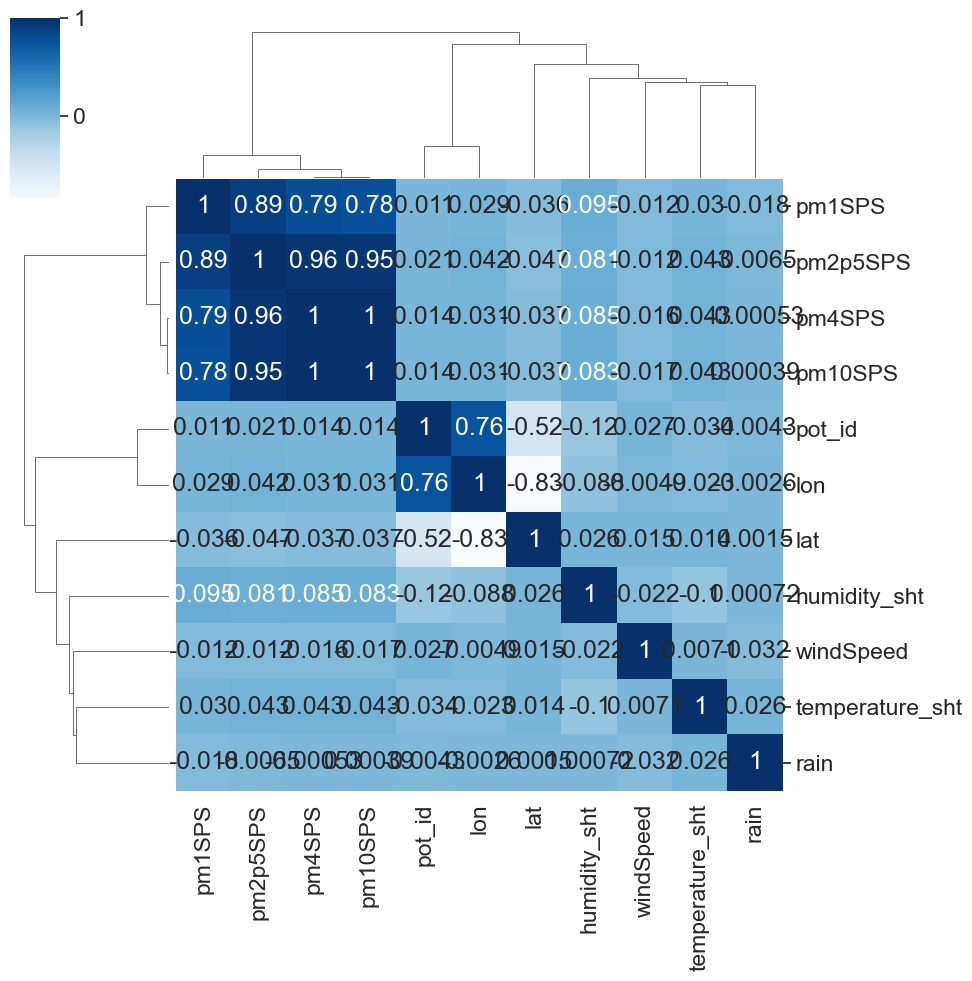

In [49]:
correlations=daily_returns.corr()
sns.set(font_scale=1.5)
sns.clustermap(correlations, cmap="Blues", annot=True);

In [52]:
finalData['pm10SPS Lagged'] = finalData['pm10SPS'].shift()
finalData['pm10SPS Lagged'].corr(finalData['pm10SPS'])

0.9344290612580386

In [53]:
finalData['pm2p5SPS'].autocorr()

0.9363213695231185

In [80]:
finalData['pm4SPS'].autocorr()

0.9355674196926168

In [57]:
import math
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [95]:
dati=finalData.loc[finalData['pot_id'] == 1024].dropna()

In [103]:
interesting2 = ["pm1SPS", "pm2p5SPS", "pm4SPS", "pm10SPS", "temperature_sht", "humidity_sht"]

for feature in list(dati.columns.values):
    if feature not in interesting2:
        dati.drop(feature, axis = 1, inplace = True)

        
dati

,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht
created_at,,,,,,
2020-06-24 18:00:00,5.527500,6.083333,6.405833,6.456667,35.633333,34.512500
2020-06-24 19:00:00,5.917500,6.625000,6.907500,6.965000,34.972500,31.958750
2020-06-25 01:00:00,3.310000,4.000000,4.390000,4.470000,28.210000,34.160000
2020-06-25 07:00:00,17.275000,18.833333,19.359167,19.456667,23.456667,47.095000
2020-06-25 08:00:00,15.290000,16.333333,16.358333,16.375833,24.204167,47.781667
...,...,...,...,...,...,...
2020-10-24 19:00:00,51.880000,48.000000,60.212500,60.692500,10.487500,70.000000
2020-10-24 20:00:00,53.495556,53.777778,71.537778,72.877778,9.915556,70.000000
2020-10-24 21:00:00,52.510000,50.000000,64.157500,64.927500,9.440000,70.000000


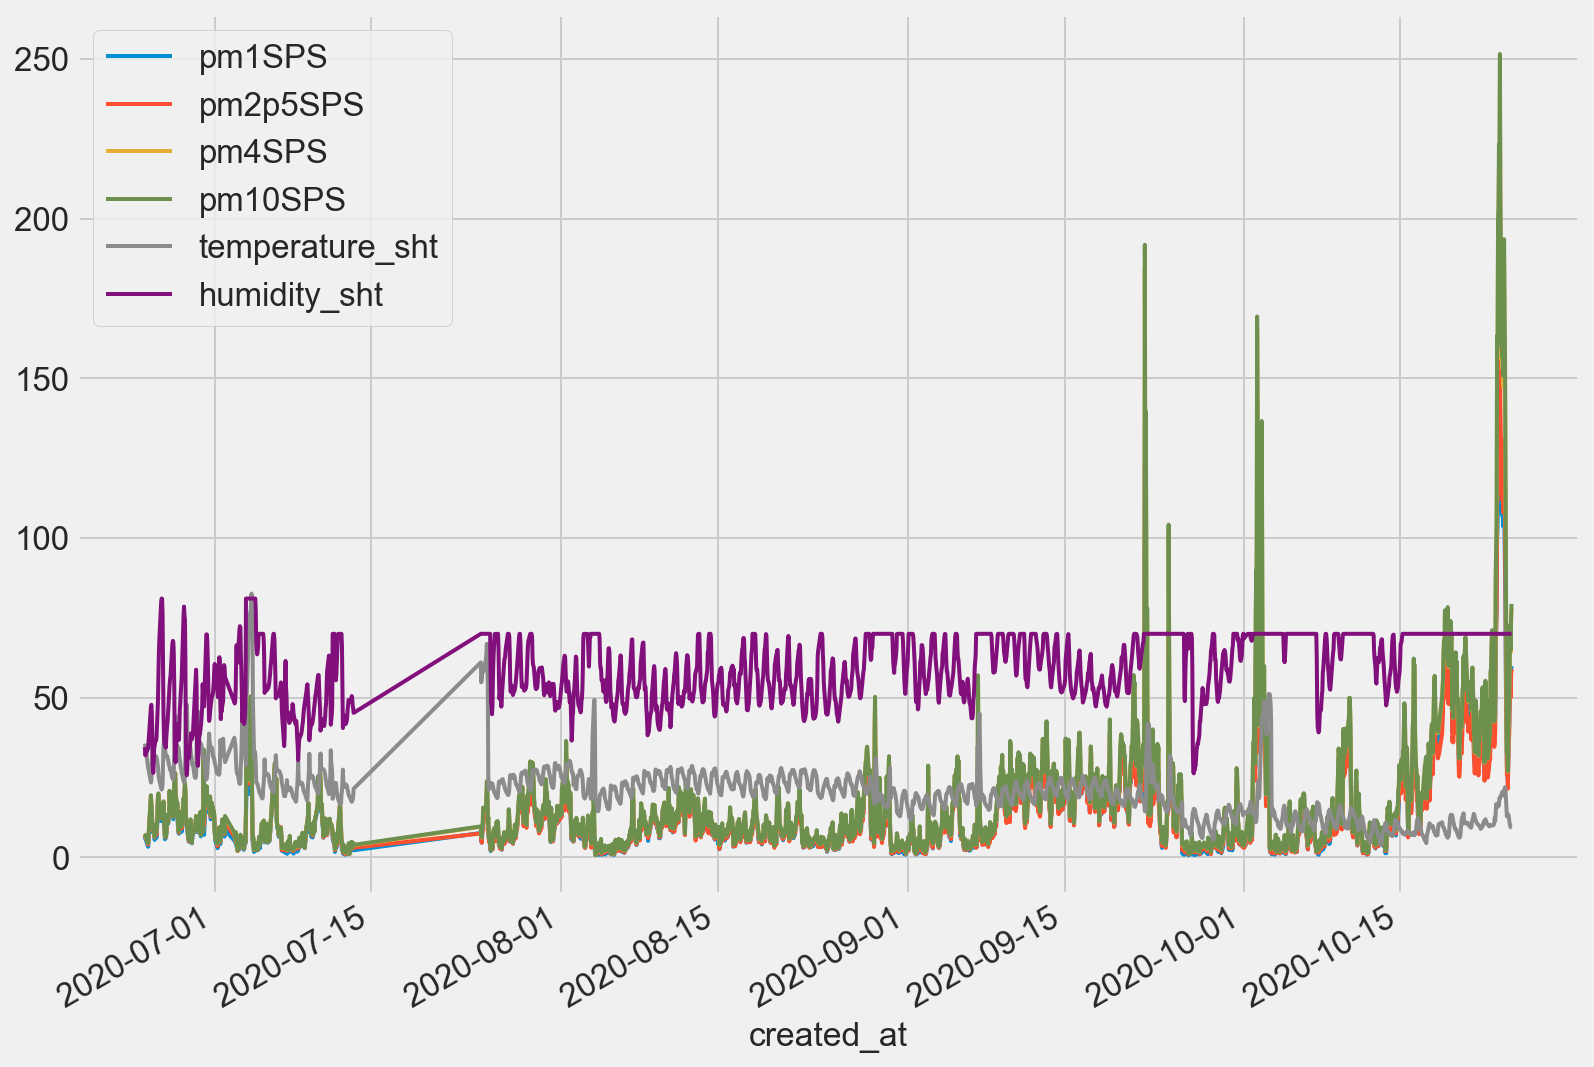

In [104]:
# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2

# predefined figsize
figsize=(12,9)
dati.plot(figsize=figsize);

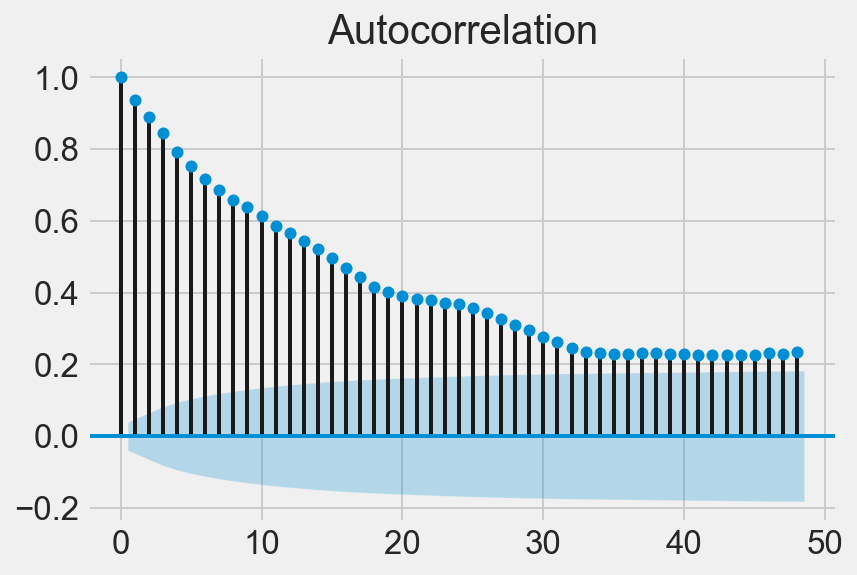

In [107]:
plot_acf(dati['pm10SPS'],lags=48)
plt.show()

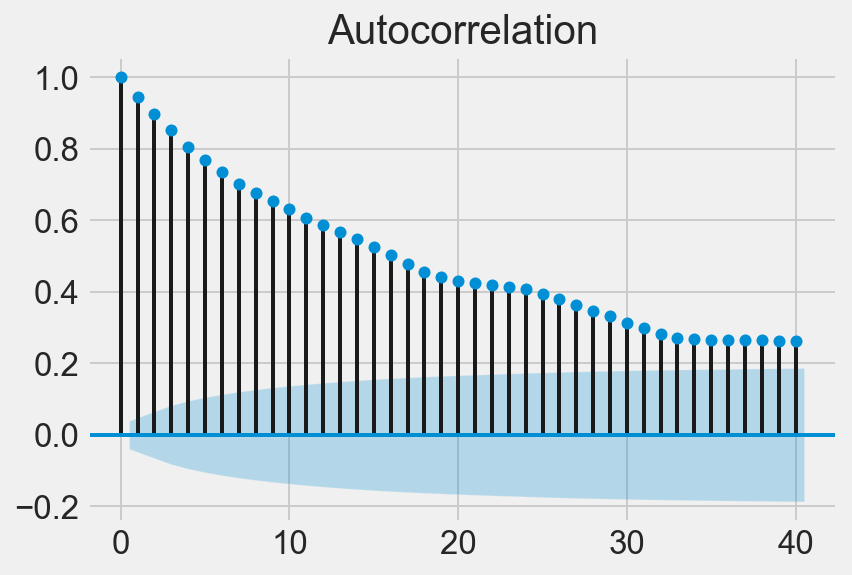

In [111]:
plot_acf(dati['pm2p5SPS'],lags=40)
plt.show()

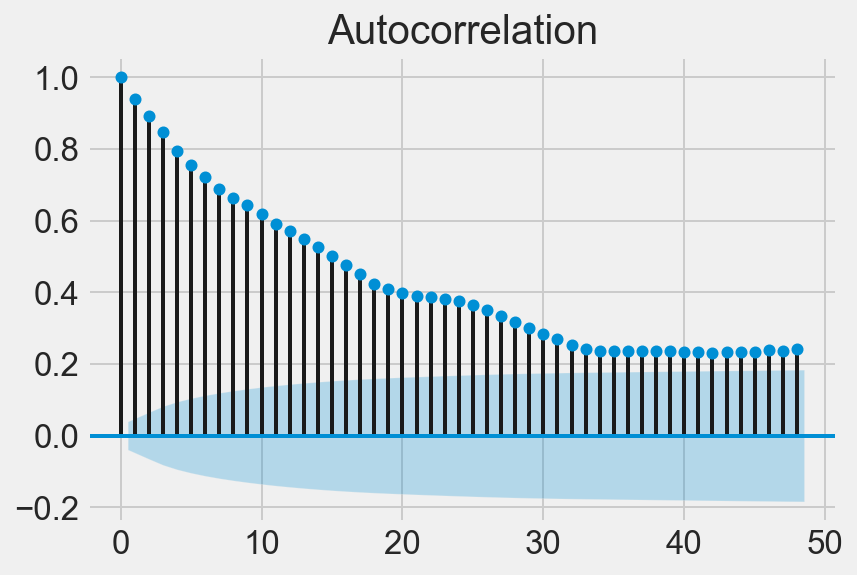

In [110]:
plot_acf(dati['pm4SPS'],lags=48)
plt.show()

In [108]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(dati['pm10SPS'])
print("p-value of pm10SPS: %.4f"%adf[1])
adf = adfuller(dati['pm2p5SPS'])
print("p-value of pm2p5SPS: %.4f"%adf[1])
adf = adfuller(dati['pm4SPS'])
print("p-value of pm4SPS: %.4f"%adf[1])


p-value of pm10SPS: 0.0034
p-value of pm2p5SPS: 0.0034
p-value of pm4SPS: 0.0036


pm10SPS,pm2p5SPS and pm4SPS have p-value which are less than than 0.05, null hypothesis that the series is random walk it is rejected (with 95% confidence level this is not a random walk).

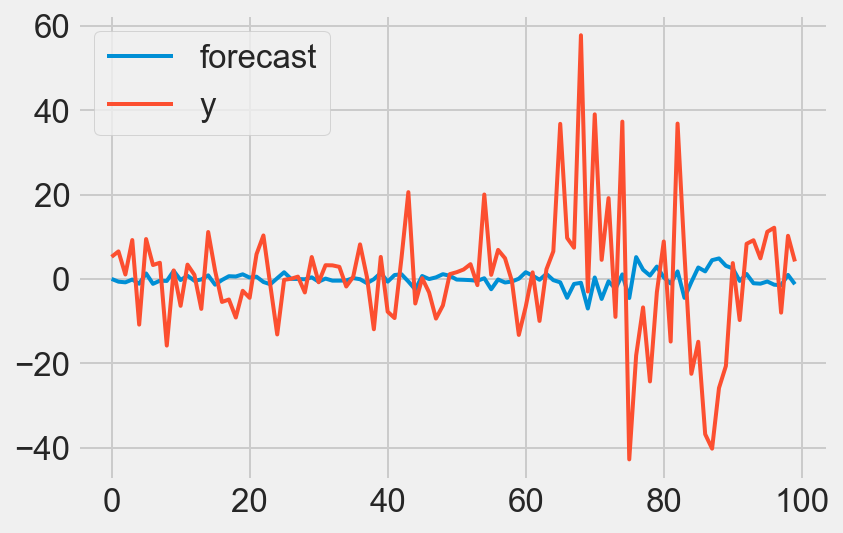

In [114]:
from statsmodels.tsa.arima_model import ARMA
pm10_model = ARMA(dati['pm10SPS'].diff().iloc[1:].values, order=(1,0))
pm10_result = pm10_model.fit()
pm10_result.plot_predict(start=-100)
plt.show()


In [116]:
rmse = math.sqrt(mean_squared_error(dati['pm10SPS'].diff().iloc[900:1000].values, pm10_result.predict(start=900,end=999)))
print("The root mean squared error is %.3f"%rmse)

The root mean squared error is 3.050


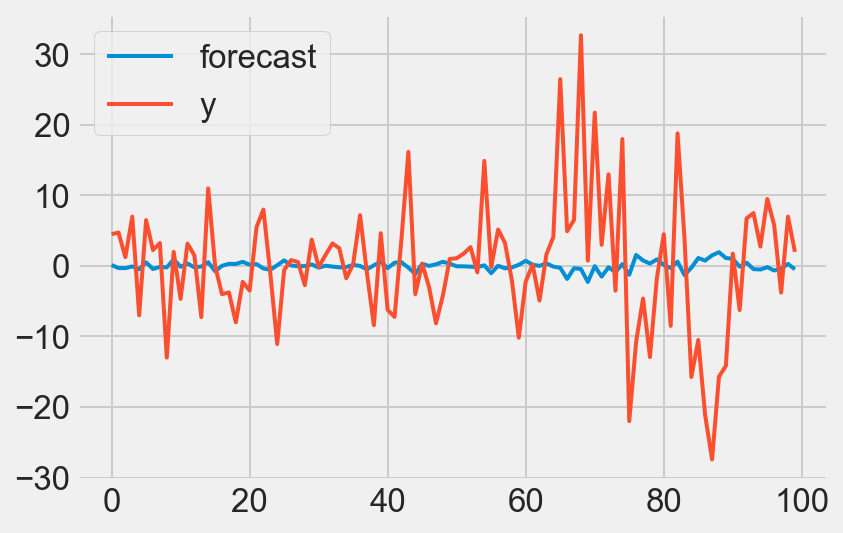

The root mean squared error is 2.265


In [117]:
pm2p5_model = ARMA(dati['pm2p5SPS'].diff().iloc[1:].values, order=(1,0))
pm2p5_result = pm2p5_model.fit()
pm2p5_result.plot_predict(start=-100)
plt.show()
rmse = math.sqrt(mean_squared_error(dati['pm2p5SPS'].diff().iloc[900:1000].values, pm2p5_result.predict(start=900,end=999)))
print("The root mean squared error is %.3f"%rmse)

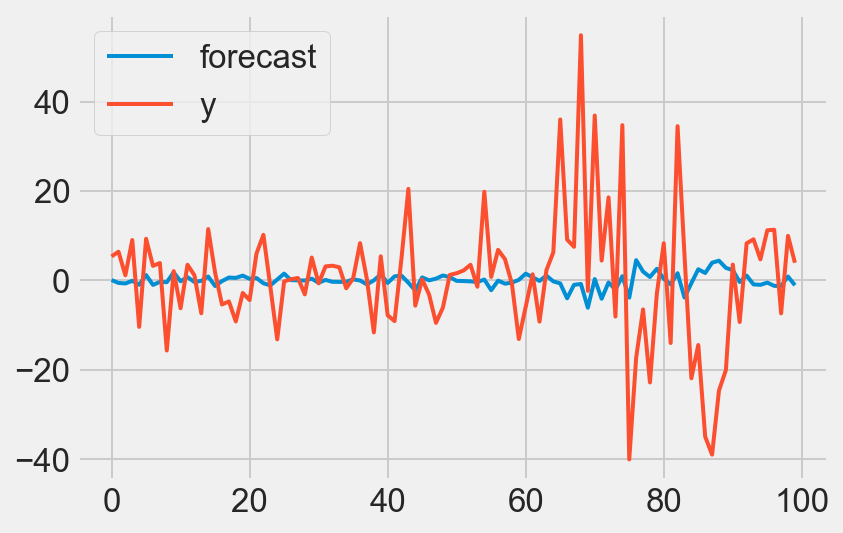

The root mean squared error is 2.972


In [118]:
pm4_model = ARMA(dati['pm4SPS'].diff().iloc[1:].values, order=(1,0))
pm4_result = pm4_model.fit()
pm4_result.plot_predict(start=-100)
plt.show()
rmse = math.sqrt(mean_squared_error(dati['pm4SPS'].diff().iloc[900:1000].values, pm4_result.predict(start=900,end=999)))
print("The root mean squared error is %.3f"%rmse)